In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pylab import mpl
import seaborn as sns

In [2]:
from matplotlib.font_manager import FontProperties

# 设置字体
font_path = '../SimHei.ttf'
font = FontProperties(fname=font_path, size=12)

In [3]:
df = pd.read_excel("sales_info.xlsx")
df.drop(columns=['省/自治区'], inplace=True)
df = df.groupby(['制造商', '产品名称','类别','子类别','地区','单价'])['年销量'].sum().reset_index()
print(df)

       制造商   产品名称    类别  子类别  地区          单价   年销量
0     Acco  孔加固材料  办公用品  装订机  东北   32.821392  2.75
1     Acco  孔加固材料  办公用品  装订机  中南   32.821392  4.50
2     Acco  孔加固材料  办公用品  装订机  华东   32.821392  9.50
3     Acco  孔加固材料  办公用品  装订机  华北   32.821392  4.50
4     Acco  孔加固材料  办公用品  装订机  西南   32.821392  4.00
...    ...    ...   ...  ...  ..         ...   ...
2627   贝尔金     鼠标    技术   配件  中南  190.309290  4.75
2628   贝尔金     鼠标    技术   配件  华东  190.309290  2.50
2629   贝尔金     鼠标    技术   配件  华北  190.309290  1.00
2630   贝尔金     鼠标    技术   配件  西北  190.309290  3.00
2631   贝尔金     鼠标    技术   配件  西南  190.309290  3.25

[2632 rows x 7 columns]


## 特征处理

In [4]:
from sklearn.preprocessing import OneHotEncoder
df=pd.get_dummies(df,columns=['制造商', '产品名称','类别','子类别','地区'])
print(df.head())

          单价   年销量  制造商_Acco  制造商_Accos  制造商_Acme  制造商_Advantus  制造商_Ames  \
0  32.821392  2.75      True      False     False         False     False   
1  32.821392  4.50      True      False     False         False     False   
2  32.821392  9.50      True      False     False         False     False   
3  32.821392  4.50      True      False     False         False     False   
4  32.821392  4.00      True      False     False         False     False   

   制造商_Avery  制造商_BIC  制造商_Barricks  ...  子类别_美术  子类别_装订机  子类别_设备  子类别_配件  \
0      False    False         False  ...   False     True   False   False   
1      False    False         False  ...   False     True   False   False   
2      False    False         False  ...   False     True   False   False   
3      False    False         False  ...   False     True   False   False   
4      False    False         False  ...   False     True   False   False   

   地区_东北  地区_中南  地区_华东  地区_华北  地区_西北  地区_西南  
0   True  False  False  Fals

## 数据集划分

In [5]:
X = df.drop(columns = ['年销量'])
y = df[['年销量']]

In [6]:
from sklearn.model_selection import train_test_split

cols = X.columns.tolist()
cols.remove('单价')
cols = [element for element in cols if element.startswith("子类别") or element.startswith("地区")]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=X[cols])
X_eval, X_test, y_eval, y_test = train_test_split(X_test, y_test, test_size=0.67, random_state=1, stratify=X_test[cols])
print("训练集数据："+str(X_train.shape[0]))
print("验证集数据："+str(X_eval.shape[0]))
print("测试集数据："+str(X_test.shape[0]))

训练集数据：1842
验证集数据：260
测试集数据：530


## 模型训练

In [7]:
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import numpy as np

In [8]:
def calculate_rmse(model, X, y):
    y_pred = model.predict(X)
    mse=mean_squared_error(y,y_pred)
    return np.sqrt(mse)
def calculate_r2(mode, X, y):
    y_pred = model.predict(X)
    r2=r2_score(y,y_pred)
    return r2

In [53]:
models = []
r2_list = []
rmse_list = []

### 线性回归

In [54]:
from sklearn.linear_model import LinearRegression

# 初始化线性回归模型
model = LinearRegression()

# 训练模型
model.fit(X_train, y_train)

LinearRegression()

In [55]:
# 评价
models.append('Linear Regression')
r2_list.append(calculate_r2(model, X_test, y_test))
rmse_list.append(calculate_rmse(model, X_test, y_test))
print(rmse_list)
print(r2_list)

[2.1674832037216403]
[0.3778804337380759]


### 岭回归

In [12]:
from sklearn.linear_model import RidgeCV, Ridge

In [56]:
alphas = np.logspace(-3, 3, 20)

12.742749857031322


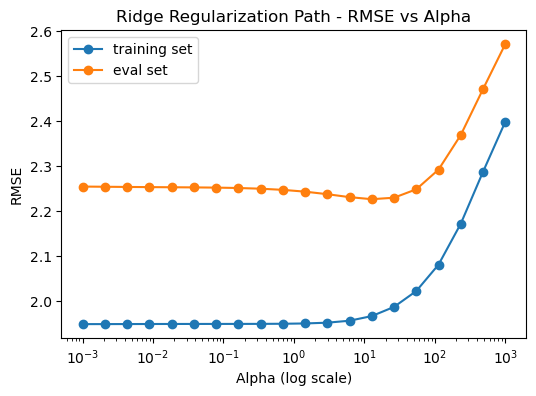

In [57]:
plt.figure(figsize=(6, 4))

# 初始化 Ridge 模型
ridge_model = Ridge()

# 存储不同 alpha 值下的 RMSE
rmse_values_train = []
rmse_values_eval = []
min_rmse = 900
best_alpha = 0

for alpha in alphas:
    ridge_model.set_params(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    
    # 在测试集上进行预测
    y_pred = ridge_model.predict(X_train)
    y_eval_pred = ridge_model.predict(X_eval)

    rmse = np.sqrt(mean_squared_error(y_eval, y_eval_pred))
    rmse_values_eval.append(rmse)
    if rmse<min_rmse:
        min_rmse = rmse
        best_alpha = alpha
    
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    rmse_values_train.append(rmse)
    

print(best_alpha)
# 绘制正则化路径图
plt.plot(alphas, rmse_values_train, marker='o',label='training set')
plt.plot(alphas, rmse_values_eval, marker='o', label='eval set')
plt.legend()
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('RMSE')
plt.title('Ridge Regularization Path - RMSE vs Alpha')
plt.show()

In [58]:
ridge_model.set_params(alpha=best_alpha)
ridge_model.fit(X_train, y_train)

Ridge(alpha=12.742749857031322)

In [59]:
# 评价
models.append('Ridge Regression')
r2_list.append(calculate_r2(ridge_model, X_test, y_test))
rmse_list.append(calculate_rmse(ridge_model, X_test, y_test))
print(rmse_list)
print(r2_list)

[2.1674832037216403, 2.1417730120076635]
[0.3778804337380759, 0.3778804337380759]


### Lasso 回归

In [17]:
from sklearn.linear_model import LassoCV, Lasso

0.004281332398719396


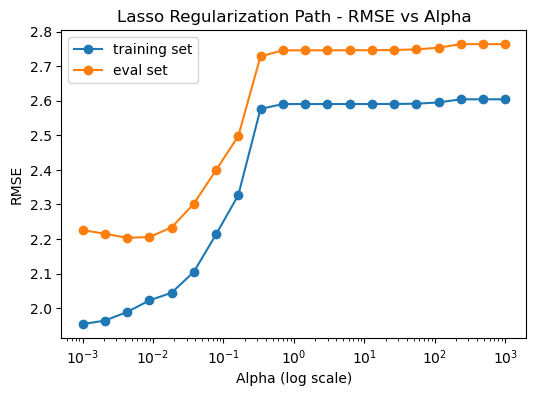

In [60]:
plt.figure(figsize=(6, 4))

# 初始化 Ridge 模型
lasso_model = Lasso()

# 存储不同 alpha 值下的 RMSE
rmse_values_train = []
rmse_values_eval = []
min_rmse = 900
best_alpha = 0

for alpha in alphas:
    lasso_model.set_params(alpha=alpha)
    lasso_model.fit(X_train, y_train)
    
    # 在测试集上进行预测
    y_pred = lasso_model.predict(X_train)
    y_eval_pred = lasso_model.predict(X_eval)

    rmse = np.sqrt(mean_squared_error(y_eval, y_eval_pred))
    rmse_values_eval.append(rmse)
    if rmse<min_rmse:
        min_rmse = rmse
        best_alpha = alpha
    
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    rmse_values_train.append(rmse)
    

print(best_alpha)
# 绘制正则化路径图
plt.plot(alphas, rmse_values_train, marker='o',label='training set')
plt.plot(alphas, rmse_values_eval, marker='o', label='eval set')
plt.legend()
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('RMSE')
plt.title('Lasso Regularization Path - RMSE vs Alpha')
plt.show()

In [61]:
lasso_model.set_params(alpha=best_alpha)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.004281332398719396)

In [62]:
# 评价
models.append('Lasso Regression')
r2_list.append(calculate_r2(lasso_model, X_test, y_test))
rmse_list.append(calculate_rmse(lasso_model, X_test, y_test))
print(rmse_list)
print(r2_list)

[2.1674832037216403, 2.1417730120076635, 2.1210637724121817]
[0.3778804337380759, 0.3778804337380759, 0.3778804337380759]


### Elastic Net

In [21]:
from sklearn.linear_model import ElasticNetCV, ElasticNet

In [63]:
# 初始化 ElasticNetCV 模型，进行交叉验证选择最佳 alpha 和 l1_ratio
elastic_net_cv_model = ElasticNetCV(alphas=np.logspace(-3, 1, 20), l1_ratio=[0, .1, .5, .7, .9, .95, 1,2], cv=5)
elastic_net_cv_model.fit(X_train, y_train)

/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4845.8440097807415, tolerance: 0.9862377121520728
  model = cd_fast.enet_coordinate_descent_gram(
/Users/helinwang/opt/anaconda3/e

/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2930.4576434347155, tolerance: 0.9862377121520728
  model = cd_fast.enet_coordinate_descent_gram(
/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2865.3564339460795, tolerance: 0.9862377121520728
  model = cd_fast.enet_coordinate_descent_gram(
/Users/hel

/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3673.491865230506, tolerance: 0.9974427189409372
  model = cd_fast.enet_coordinate_descent_gram(
/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3457.627389388183, tolerance: 0.9974427189409372
  model = cd_fast.enet_coordinate_descent_gram(
/Users/helin

/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4871.46458109027, tolerance: 1.0248844513229305
  model = cd_fast.enet_coordinate_descent_gram(
/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4774.518303061782, tolerance: 1.0248844513229305
  model = cd_fast.enet_coordinate_descent_gram(
/Users/helinw

/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5017.195972607371, tolerance: 1.018142384667573
  model = cd_fast.enet_coordinate_descent_gram(
/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5000.460465410429, tolerance: 1.018142384667573
  model = cd_fast.enet_coordinate_descent_gram(
/Users/helinwa

/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2976.2243220988967, tolerance: 1.018142384667573
  model = cd_fast.enet_coordinate_descent_gram(
/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2924.6570034794045, tolerance: 1.018142384667573
  model = cd_fast.enet_coordinate_descent_gram(
/Users/helin

/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3435.3677030549293, tolerance: 0.9699868427747613
  model = cd_fast.enet_coordinate_descent_gram(
/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3257.9553297636344, tolerance: 0.9699868427747613
  model = cd_fast.enet_coordinate_descent_gram(
/Users/hel

/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 1.0248844513229305
  model = cd_fast.enet_coordinate_descent_gram(
/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 1.0248844513229305
  model = cd_fast.enet_coordinate_descent_gram(
/Users/helinwang/opt/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: nan, tolerance: 1.0248844513229305
  model = cd_fast.enet_coordinate_descent_gram(
/Users/helinwang/opt/anaconda3/envs/pytorch

ElasticNetCV(alphas=array([1.00000000e-03, 1.62377674e-03, 2.63665090e-03, 4.28133240e-03,
       6.95192796e-03, 1.12883789e-02, 1.83298071e-02, 2.97635144e-02,
       4.83293024e-02, 7.84759970e-02, 1.27427499e-01, 2.06913808e-01,
       3.35981829e-01, 5.45559478e-01, 8.85866790e-01, 1.43844989e+00,
       2.33572147e+00, 3.79269019e+00, 6.15848211e+00, 1.00000000e+01]),
             cv=5, l1_ratio=[0, 0.1, 0.5, 0.7, 0.9, 0.95, 1, 2])

In [64]:
# 获取最佳 alpha 和 l1_ratio
best_alpha = elastic_net_cv_model.alpha_
best_l1_ratio = elastic_net_cv_model.l1_ratio_
print(f'Best Alpha: {best_alpha}')
print(f'Best L1 Ratio: {best_l1_ratio}')

Best Alpha: 0.011288378916846888
Best L1 Ratio: 1.0


In [65]:
# 初始化 ElasticNet 模型，使用最佳参数
elastic_net_model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio)
elastic_net_model.fit(X_train, y_train)

ElasticNet(alpha=0.011288378916846888, l1_ratio=1.0)

In [66]:
# 评价
models.append('Elastic Net')
r2_list.append(calculate_r2(elastic_net_model, X_test, y_test))
rmse_list.append(calculate_rmse(elastic_net_model, X_test, y_test))
print(rmse_list)
print(r2_list)

[2.1674832037216403, 2.1417730120076635, 2.1210637724121817, 2.1374321136652705]
[0.3778804337380759, 0.3778804337380759, 0.3778804337380759, 0.3778804337380759]


### 随机森林

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [9]:
# 定义随机森林模型
rf_model = RandomForestRegressor()

# 使用GridSearchCV进行超参数调优
param_grid = {
    'n_estimators': [150, 200],
    'max_depth': [5, 7, 10],
    'min_samples_split': [2, 5, 7, 10]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train.iloc[:,0])

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 7, 10],
                         'min_samples_split': [2, 5, 7, 10],
                         'n_estimators': [150, 200]},
             scoring='neg_mean_squared_error')

[0.01610304 0.01882049 0.02058151 0.0333304  0.03363928 0.04164421
 0.04712034 0.0633432  0.25256309 0.26007536]


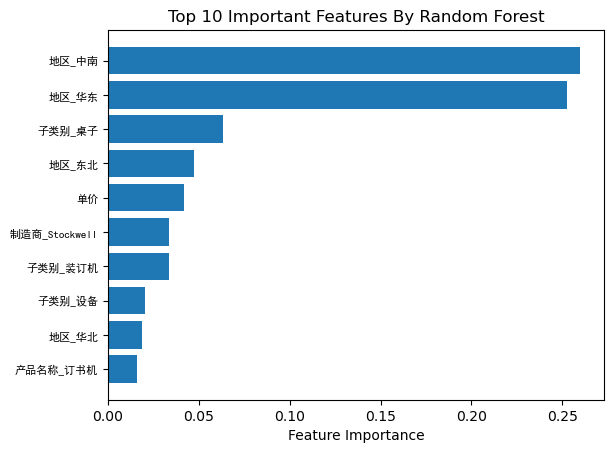

In [10]:
importances=grid_search.best_estimator_.feature_importances_
top10_indices = np.argsort(importances)[-10:]
print(importances[top10_indices])
feature_names = X.columns.tolist()
# 获取前20个最重要的特征名称
top10_feature_names = [feature_names[idx] for idx in top10_indices]

# 绘制条状图
plt.barh(range(10), importances[top10_indices], align='center')
plt.yticks(range(10), top10_feature_names, fontproperties=FontProperties(fname=font_path, size=8))
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features By Random Forest')
plt.show()

In [68]:
# 获取最佳参数
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

Best Parameters: {'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 200}


In [69]:
best_model = grid_search.best_estimator_
# 评价
models.append('Random Forest')
r2_list.append(calculate_r2(best_model, X_test, y_test))
rmse_list.append(calculate_rmse(best_model, X_test, y_test))
print(rmse_list)
print(r2_list)

[2.1674832037216403, 2.1417730120076635, 2.1210637724121817, 2.1374321136652705, 2.2031097455867665]
[0.3778804337380759, 0.3778804337380759, 0.3778804337380759, 0.3778804337380759, 0.3778804337380759]


### XGBoost

In [11]:
model = xgb.XGBRegressor(early_stopping_rounds=10,eval_metric=["rmse"])

param_grid = {
    'learning_rate': [0.05,0.1, 0.13],
    'n_estimators': [130,150,170],
    'max_depth': [5,10, 15],
}
# 使用GridSearchCV进行网格搜索
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', 
                           n_jobs=-1, verbose=2)

# 使用X_eval和y_eval作为验证集
eval_set = [(X_train, y_train), (X_eval, y_eval)]  
grid_search.fit(X_train, y_train, eval_set=eval_set, verbose=False)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=10,
                                    enable_categorical=False,
                                    eval_metric=['rmse'], feature_types=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.13],
                         'max_depth': [5, 10, 15],
                         'n_estimators': [130, 150, 170]},
             scoring='neg_mean_squared_error', verbose=2)

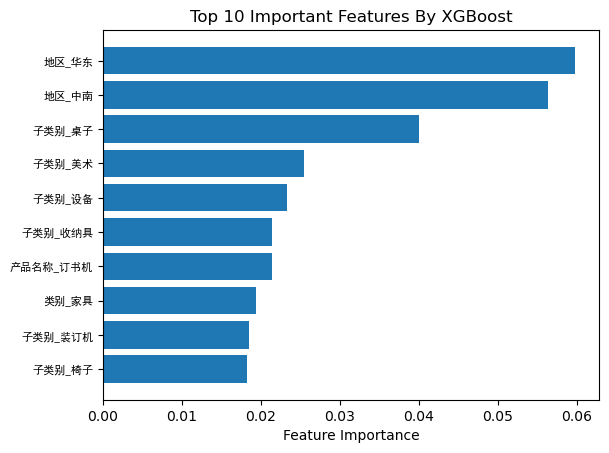

[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=150; total time=   1.8s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=150; total time=   3.0s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=130; total time=   4.6s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=150; total time=   5.1s
[CV] END .learning_rate=0.05, max_depth=15, n_estimators=130; total time=   5.5s
[CV] END .learning_rate=0.05, max_depth=15, n_estimators=170; total time=   5.6s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=150; total time=   2.2s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=170; total time=   2.7s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=150; total time=   4.3s
[CV] END ..learning_rate=0.1, max_depth=15, n_estimators=130; total time=   3.4s
[CV] END ..learning_rate=0.1, max_depth=15, n_estimators=150; total time=   2.9s
[CV] END ..learning_rate=0.13, max_depth=5, n_estimators=130; total time=   1.8s
[CV] END ..learning_rate=0.1

In [12]:
importances=grid_search.best_estimator_.feature_importances_

top10_indices = np.argsort(importances)[-10:]
feature_names = X.columns.tolist()
# 获取前20个最重要的特征名称
top10_feature_names = [feature_names[idx] for idx in top10_indices]

# 绘制条状图
plt.barh(range(10), importances[top10_indices], align='center')
plt.yticks(range(10), top10_feature_names, fontproperties=FontProperties(fname=font_path, size=8))
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features By XGBoost')
plt.show()

In [71]:
# 打印最佳参数
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 130}


In [72]:
best_model = grid_search.best_estimator_
# 评价
models.append('XGBoost')
r2 = r2_score(y_test,best_model.predict(X_test))
r2_list.append(r2)
rmse_list.append(calculate_rmse(best_model, X_test, y_test))
print(rmse_list)
print(r2_list)

[2.1674832037216403, 2.1417730120076635, 2.1210637724121817, 2.1374321136652705, 2.2031097455867665, 2.1624900005709247]
[0.3778804337380759, 0.3778804337380759, 0.3778804337380759, 0.3778804337380759, 0.3778804337380759, 0.38074346983587015]


### KNN

In [33]:
from sklearn.neighbors import KNeighborsRegressor

11


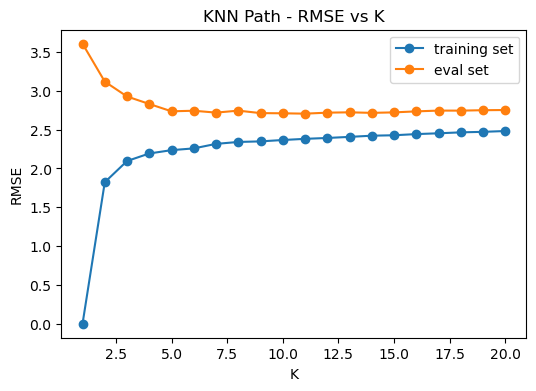

In [76]:
from sklearn.metrics import make_scorer
ks = range(1, 21)             #用来保存KNN模型的邻居个数
plt.figure(figsize=(6, 4))

# 初始化 Ridge 模型
knn = KNeighborsRegressor()

# 存储不同 alpha 值下的 RMSE
rmse_values_train = []
rmse_values_eval = []
min_rmse = 900
best_k = 0

for k in ks:
    knn.set_params(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # 在测试集上进行预测
    y_pred = knn.predict(X_train)
    y_eval_pred = knn.predict(X_eval)

    rmse = np.sqrt(mean_squared_error(y_eval, y_eval_pred))
    rmse_values_eval.append(rmse)
    if rmse<min_rmse:
        min_rmse = rmse
        best_k = k
    
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    rmse_values_train.append(rmse)
    

print(best_k)
# 绘制正则化路径图
plt.plot(ks, rmse_values_train, marker='o',label='training set')
plt.plot(ks, rmse_values_eval, marker='o', label='eval set')
plt.legend()
plt.xlabel('K')
plt.ylabel('RMSE')
plt.title('KNN Path - RMSE vs K')
plt.show()

In [74]:
# 定义KNN回归模型
knn = KNeighborsRegressor()
knn.set_params(n_neighbors=7)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=7)

In [77]:
best_model = grid_search.best_estimator_
models.append("KNN")
rmse_list.append(calculate_rmse(best_model, X_test, y_test))
r2 = r2_score(y_test,best_model.predict(X_test))
r2_list.append(r2)
print(rmse_list)
print(r2_list)

[2.1674832037216403, 2.1417730120076635, 2.1210637724121817, 2.1374321136652705, 2.2031097455867665, 2.1624900005709247, 2.1624900005709247]
[0.3778804337380759, 0.3778804337380759, 0.3778804337380759, 0.3778804337380759, 0.3778804337380759, 0.38074346983587015, 0.38074346983587015]


### ANN

In [37]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid

In [78]:
ann = MLPRegressor(max_iter=400)  # 可根据实际情况调整 max_iter
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 50), (100, 50, 25)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

# 早停止
best_mse = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    ann.set_params(**params)
    ann.fit(X_train, y_train.iloc[:,0])
    
    y_eval_pred = ann.predict(X_eval)
    mse = mean_squared_error(y_eval, y_eval_pred)
   
    if mse < best_mse:
        best_mse = mse
        best_params = params

    # 如果在一定迭代次数内性能没有提升，提前终止训练
    if ann.n_iter_ > 50 and mse > 1.5 * best_mse:
        break

In [79]:
print("Best Parameters: ", best_params)

Best Parameters:  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling'}


In [80]:
ann = MLPRegressor(max_iter=400)
ann.set_params(**best_params)
ann.fit(X_train, y_train.iloc[:,0])

MLPRegressor(alpha=0.001, hidden_layer_sizes=(50, 50),
             learning_rate='invscaling', max_iter=400)

In [81]:
models.append("ANN")
rmse_list.append(calculate_rmse(ann, X_test, y_test))
r2 = r2_score(y_test,ann.predict(X_test))
r2_list.append(r2)
print(rmse_list)
print(r2_list)

2.226738743207891
0.34339995203705675


### GBDT

In [42]:
from sklearn.ensemble import GradientBoostingRegressor

In [83]:
gbdt = GradientBoostingRegressor()

# 定义参数网格
param_grid = {
    'n_estimators': [50,100,150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10,15]
}

# 使用 GridSearchCV 进行参数调整
grid_search = GridSearchCV(estimator=gbdt, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train.iloc[:,0])

[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=130; total time=   1.9s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=150; total time=   3.4s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=130; total time=   3.9s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=150; total time=   4.0s
[CV] END .learning_rate=0.05, max_depth=15, n_estimators=130; total time=   4.2s
[CV] END .learning_rate=0.05, max_depth=15, n_estimators=170; total time=   4.3s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=130; total time=   1.8s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=170; total time=   2.1s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=130; total time=   2.2s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=170; total time=   1.9s
[CV] END ..learning_rate=0.1, max_depth=15, n_estimators=130; total time=   2.7s
[CV] END ..learning_rate=0.1, max_depth=15, n_estimators=170; total time=   2.7s
[CV] END ..learning_rate=0.1

[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=150; total time=   2.0s
[CV] END ..learning_rate=0.05, max_depth=5, n_estimators=150; total time=   3.2s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=130; total time=   4.3s
[CV] END .learning_rate=0.05, max_depth=10, n_estimators=170; total time=   3.1s
[CV] END .learning_rate=0.05, max_depth=15, n_estimators=130; total time=   5.0s
[CV] END .learning_rate=0.05, max_depth=15, n_estimators=170; total time=   4.6s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=150; total time=   2.3s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=170; total time=   1.6s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=150; total time=   3.7s
[CV] END ..learning_rate=0.1, max_depth=15, n_estimators=130; total time=   2.3s
[CV] END ..learning_rate=0.1, max_depth=15, n_estimators=150; total time=   2.5s
[CV] END ..learning_rate=0.13, max_depth=5, n_estimators=130; total time=   1.6s
[CV] END ..learning_rate=0.1

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [5, 10, 15],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_mean_squared_error')

In [84]:
# 输出最优参数
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


In [85]:
best_model = grid_search.best_estimator_
models.append("GBDT")
rmse_list.append(calculate_rmse(best_model, X_test, y_test))
r2 = r2_score(y_test,best_model.predict(X_test))
r2_list.append(r2)
print(rmse_list)
print(r2_list)

[2.1674832037216403, 2.1417730120076635, 2.1210637724121817, 2.1374321136652705, 2.2031097455867665, 2.1624900005709247, 2.1624900005709247, 2.226738743207891, 2.1868339167485926]
[0.3778804337380759, 0.3778804337380759, 0.3778804337380759, 0.3778804337380759, 0.3778804337380759, 0.38074346983587015, 0.38074346983587015, 0.34339995203705675, 0.3667226123118834]


## 模型性能对比

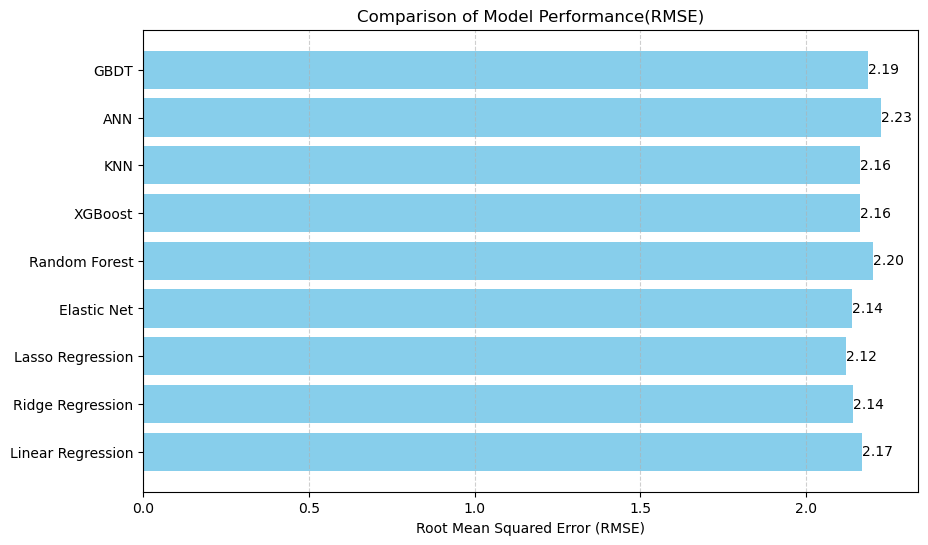

In [91]:
# 创建条形图
plt.figure(figsize=(10, 6))
plt.barh(models, rmse_list, color='skyblue')
plt.xlabel('Root Mean Squared Error (RMSE)')
plt.title('Comparison of Model Performance(RMSE)')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# 显示 RMSE 值
for index, value in enumerate(rmse_list):
    plt.text(value, index, f'{value:.2f}', va='center', fontsize=10)

# 显示图形
plt.show()

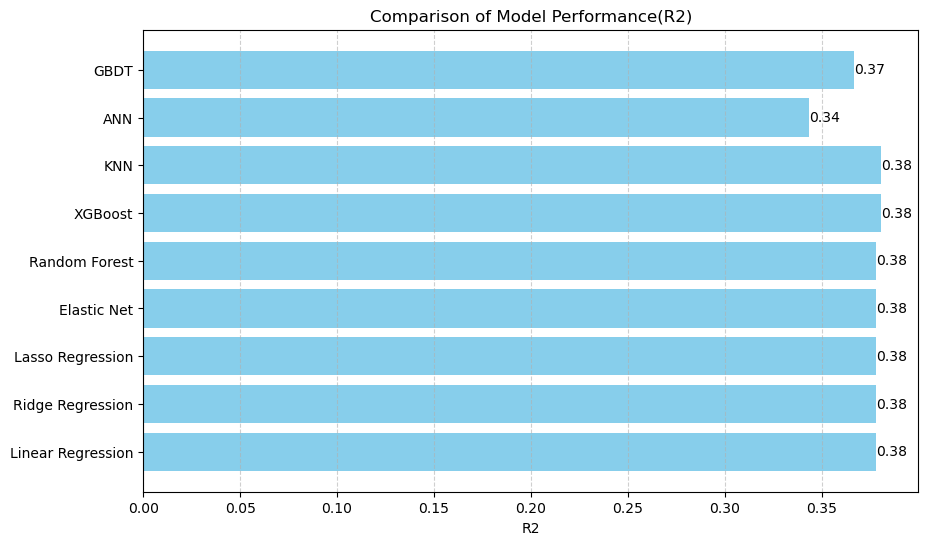

In [92]:
# 创建条形图
plt.figure(figsize=(10, 6))
plt.barh(models, r2_list, color='skyblue')
plt.xlabel('R2')
plt.title('Comparison of Model Performance(R2)')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# 显示 RMSE 值
for index, value in enumerate(r2_list):
    plt.text(value, index, f'{value:.2f}', va='center', fontsize=10)

# 显示图形
plt.show()